## Opening Suite Generator

Generates unique opening positions based on the neural network weights which
was trained on the lichess.org database.
Every move a new move is sampled from the neural net probability distribtions and applied to the game state.
If the new resulting position has not been added to the suite before, the move ordering is added to the opening suite.
Otherwise a new move is sampled from the resulting position.
No noise is applied to the probability distribution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import chess
import chess.variant
import matplotlib.pyplot as plt
import numpy as np
import sys
import glob
sys.path.insert(0,'../../')
from DeepCrazyhouse.src.runtime.color_logger import enable_color_logging
from DeepCrazyhouse.src.domain.agent.neural_net_api import NeuralNetAPI
from DeepCrazyhouse.src.domain.agent.player.mcts_agent import MCTSAgent
from DeepCrazyhouse.src.domain.agent.player.raw_net_agent import RawNetAgent
from DeepCrazyhouse.src.domain.variants.game_state import GameState

from tqdm import tnrange, tqdm_notebook
import chess.pgn
from time import time
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [4]:
batch_size = 8 #1 #8
alpha = 0.2
epsilon = 0.25
nb_openings = int(1e3)

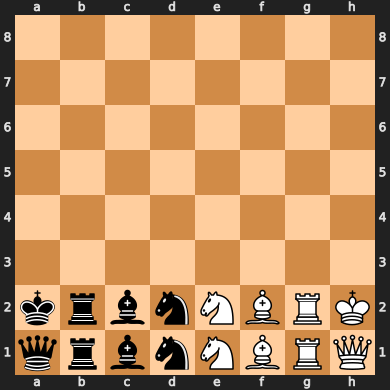

In [5]:
# Create a folder and put all models you want to use in subfolders
# Name the subfolders according to the variants

models_dir = '/home/maxalex/Documents/Training-Runs/SL/7epochs/all_7epoch_models/'


selected_variant = 'racingkings'
assert selected_variant in ['3check', 'antichess', 'atomic', 'chess960', 'crazyhouse', 'horde', 'kingofthehill', 'racingkings']

if selected_variant == '3check':
    board = chess.variant.ThreeCheckBoard()
    header_name = 'ThreeCheck'
elif selected_variant == 'antichess':
    board = chess.variant.AntichessBoard()
    header_name = 'Antichess'
elif selected_variant == 'atomic':
    board = chess.variant.AtomicBoard()
    header_name = 'Atomic'
elif selected_variant == 'chess960':
    board = chess.Board(chess960=True)
    header_name = 'Chess960'
elif selected_variant == 'crazyhouse':
    board = chess.variant.CrazyhouseBoard()
    header_name = 'Crazyhouse'
elif selected_variant == 'horde':
    board = chess.variant.HordeBoard()
    header_name = 'Horde'
elif selected_variant == 'kingofthehill':
    board = chess.variant.KingOfTheHillBoard()
    header_name = 'King of the Hill'
elif selected_variant == 'racingkings':
    board = chess.variant.RacingKingsBoard()
    header_name = 'Racing Kings'
    
param_files = glob.glob(models_dir + selected_variant + '/*.params')
assert len(param_files) == 1
params_path = param_files[0]
    
json_files = glob.glob(models_dir + selected_variant + '/*.json')
assert len(json_files) == 1
arch_path = json_files[0]
    
state = GameState(board)
board

In [6]:
net = NeuralNetAPI(ctx='cpu', batch_size=batch_size,
                  model_architecture_dir=arch_path,
                  model_weights_dir=params_path)

self.symbol_path: /home/maxalex/Documents/Training-Runs/SL/7epochs/all_7epoch_models/racingkings/model-1.45871-0.541-symbol.json
self.params_path: /home/maxalex/Documents/Training-Runs/SL/7epochs/all_7epoch_models/racingkings/model-1.45871-0.541-0026.params


In [7]:
raw_agent = RawNetAgent(net)

In [8]:
def plot_moves_with_prob(moves, probs, only_top_x=None):
    
    # revert the ordering afterwards
    idx_order = np.argsort(probs)[::-1]
    
    if only_top_x is not None and only_top_x < len(idx_order):
        idx_order = idx_order[:only_top_x]
    
    #moves_ordered = moves[range(len(moves))] #idx_order[::-1]]
    probs_ordered = [] #probs[idx_order]
    
    moves_ordered = []
    for idx in idx_order:
        probs_ordered.append(probs[idx])
        moves_ordered.append(moves[idx])
        
    plt.barh(range(len(probs_ordered)), probs_ordered)
    plt.yticks(range(len(moves_ordered)), moves_ordered)


In [9]:
t_s = time()
pred_value, legal_moves, p_vec_small, cp, depth, nodes, time_elapsed_s, nps, pv = raw_agent.evaluate_board_state(state)
print('Elapsed time: %.4fs' % (time()-t_s))

Elapsed time: 0.0430s


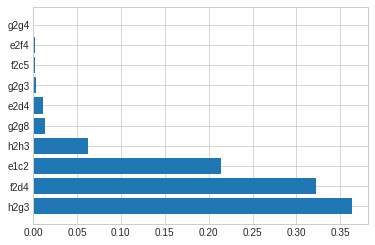

In [10]:
plot_moves_with_prob(legal_moves, p_vec_small, only_top_x=10)

In [11]:
dirichlet_noise = np.random.dirichlet([alpha] * len(legal_moves))
#dirichlet_noise = np.ones(len(legal_moves)) * 1/len(legal_moves)
p_vec_small = (1 - epsilon) * p_vec_small + epsilon * dirichlet_noise

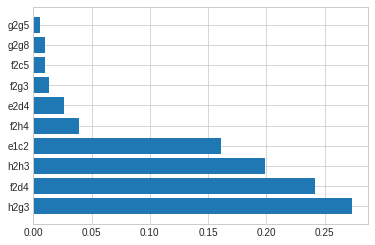

In [12]:
plot_moves_with_prob(legal_moves, p_vec_small, only_top_x=10)

In [13]:
opening_states = {}

In [ ]:
plys_state = np.zeros(nb_openings)
for i in tnrange(nb_openings, desc='generated openings'):
    # create a new entry in the dictionary
    state.new_game()
    game = chess.pgn.Game()
    game.headers["Event"] = "Lichess Opening Explorer"# (0.25 Dirichlet Noise)"
    game.headers["Variant"] = header_name #"crazyhouse"
    game.headers["Date"] = "2021.07.02" #"2018.12.31"
    plys = 0

    node = None
    while True:
        plys += 1
        pred_value, legal_moves, p_vec_small, cp, depth, nodes, time_elapsed_s, nps, pv = raw_agent.evaluate_board_state(state)
        #dirichlet_noise = np.random.dirichlet([alpha] * len(legal_moves))
        #p_vec_small = (1 - epsilon) * p_vec_small + epsilon * dirichlet_noise

        # make sure the probabilities will sum up to 1
        #p_vec_small /= p_vec_small.sum()
        sel_move = np.random.choice(legal_moves, p=p_vec_small)
        
        if node is None:
            # create a new node
            node = game.add_variation(sel_move)
        else:
            # add the move to the existing node
            node = node.add_variation(sel_move)

        #print(sel_move.uci(), end=" ")
        state.apply_move(sel_move)
        transpos_key = state.get_transposition_key()
        if transpos_key not in opening_states:
            opening_states[transpos_key] = True
            plys_state[i] = plys
            break
    #print()
    
    with open(f'lichess_{selected_variant}_startpos.pgn', 'a') as f:
        f.write(str(game) +'\n\n')


/home/maxalex/anaconda3/envs/ara/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


generated openings:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print('Statistics: Half Moves %.2f +/- %.2f' % (plys_state.mean(), plys_state.std()))